In [ ]:
#####################################################################################
#########                                                              #############
#########   Linear regression model between GPP and SIF                #############
#########                                                              #############
####################################################################################

In [1]:

# Import required libraries

import warnings
warnings.filterwarnings('ignore')

import glob
from datetime import datetime, timedelta 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import linregress
import scipy
import math
from math import sqrt

from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import r2_score

import statsmodels.formula.api as smf
import statsmodels as sm

%matplotlib inline
sns.set_style('whitegrid')


In [2]:
# Controling the label, font, axes and legend sizes
#plt.rc('font', size=16, weight='bold') #controls default text sizesns.set_style('whitegrid')
plt.rc('font', size=16) #controls default text sizesns.set_style('whitegrid')
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels


In [3]:
# Set up your working directory
import os
os.getcwd()
os.chdir("D:/SIF_GPP_PRI_Tropomi/Linear_Regression_output/LR_Stats/LAST_testing/figures")


In [4]:
# load your merged data set

df_merge = pd.read_csv('D:\LCC/DataGPPfiltered.csv')

# convert your datetime into datetime format and set it as index 
df_merge['Timestamp'] = pd.to_datetime(df_merge['Timestamp'], format ='%m/%d/%Y')

#Filtering based on the distance (<=5 km) and cloud fraction (<=15%)
df_merge = df_merge[(df_merge['distance']<= 5)&(df_merge['cloud_fraction']<=0.15)]

# Outliers filtering
df_merge = df_merge[(df_merge['Err_mesure']<=0.15)&(df_merge['Err_mesure']>=-0.15)]

# Drop your columns 
df_merge['Timestamp'] = df_merge.set_index(df_merge['Timestamp'], inplace = True)
df_merge = df_merge.drop(columns = ['Timestamp'])

# Convert categorical variables as numeric, Biomes and Sites.
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

# label_encoder object
label_encoder =LabelEncoder()
# Encode labels in column. 
df_merge['IGBP_site']= label_encoder.fit_transform(df_merge['Biome_site'])
df_merge['Site']= label_encoder.fit_transform(df_merge['Site_name'])

#Rename daily averaged SIF
df_merge.rename(columns={'daily_averaged_SIF':'SIF_Daily'}, inplace = True)

# convert site name to liste and sort the data frame
listSites = df_merge["Site_name"].unique().tolist()
listSites = sorted(listSites)

# replace null GPP values as nan
df_merge['GPP'][df_merge['GPP']==0] = np.nan

#Drop nan values 
df_merge.dropna(subset = ['GPP'], inplace = True)

#get dayofyear from dataframe index
df_merge['DOY'] = df_merge.index.dayofyear

df_merge


,sif,sif_err,sif_relative,dcSIF,cloud_fraction,sza,vza,phase_angle,daily_correction_factor,lat,...,NEE_VUT_REF,PPFD_OUT,TA_F,VPD_F,Year,DoY,saveGPP,IGBP_site,Site,DOY
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-02-07,-0.1047,0.2426,-0.4586,-0.0265,0.0000,66.599998,24.200001,-78.300003,0.2535,51.301701,...,NaN,NaN,NaN,NaN,2018,737098,1.574183,5,0,38
2018-02-14,0.4536,0.2607,1.6363,0.1202,0.0000,64.400002,50.799999,91.500000,0.2651,51.308800,...,NaN,NaN,NaN,NaN,2018,737105,1.546119,5,0,45
2018-02-16,0.2810,0.2599,1.0219,0.0769,0.0450,64.199997,15.300000,-58.700001,0.2737,51.270401,...,NaN,NaN,NaN,NaN,2018,737107,1.833989,5,0,47
2018-02-16,0.0293,0.2675,0.0986,0.0080,0.0056,64.300003,15.300000,-58.799999,0.2736,51.332802,...,NaN,NaN,NaN,NaN,2018,737107,1.833989,5,0,47
2018-02-18,0.3418,0.2953,0.8903,0.0924,0.0196,62.900002,30.600000,-78.599998,0.2702,51.337101,...,NaN,NaN,NaN,NaN,2018,737109,1.639252,5,0,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-25,0.3064,0.3227,0.9896,0.0956,0.0433,65.500000,35.400002,85.400002,0.3118,64.242798,...,125.159621,41.86,7.238958,0.580417,2020,738059,4.102004,3,39,269
2020-10-03,-0.0848,0.2930,-0.3594,-0.0248,0.0000,68.699997,2.600000,-67.500000,0.2926,64.250198,...,NaN,NaN,NaN,NaN,2020,738067,3.078926,3,39,277
2020-10-03,0.0474,0.2963,0.1945,0.0139,0.0000,68.699997,2.300000,-67.599998,0.2925,64.238403,...,NaN,NaN,NaN,NaN,2020,738067,3.078926,3,39,277


In [7]:
#########################################################################################################################
# Site specific Linear Regression SIF-GPP using Statsmodels scipy linregress function

from scipy import stats
from scipy.stats import linregress

########################################################################################################################
# Note: In jupyter lab, I had some issues generating the confidence interval on the intercept.
#To solve the problem, I used the kaggle plateform and it worked very well.
#######################################################################################################################
# Data préparation 
# Convert Site_name as a list
listSites = df_merge["Site_name"].unique().tolist()

# Sorting the Site name

listSites = sorted(listSites)
print(listSites)

# create empty lists for LR stats

Lreg = []; R = []; rval =[]; slo = []; inter = []; std = []; p_val = []; ConfInt = []; shape = []; Confinter =[];

# Create an empty dataframe

df = pd.DataFrame()

# use a for loop to gerenate a Linear Regression for each Site.

for i in listSites:
    r_sample = df_merge[df_merge.Site_name.isin([i])]
    sample_x = r_sample["SIF_Daily"].values
    sample_y = r_sample["GPP"].values
    df_shape = r_sample["GPP"].shape
    distance = r_sample["distance"].values
    #distance = distance<=2.5

    # Linear regression between SIF and GPP
    
    LR = stats.linregress(sample_x,  sample_y)
    
    # Calcultate the LR stats
    
    R_2 = LR.rvalue**2  # Coefficient of determination
    r = LR.rvalue       # Coefficient of correlation
    slope = LR.slope    # slope of the LR
    intercept = LR.intercept # intercept of the LR
    stderr = LR.stderr  # Standard Error of the LR
    p_value = LR.pvalue  # P_value of the LR
    
    # Put each Variable into a list in order to generate a Dataframe
    
    R.append(R_2); rval.append(r); slo.append(slope); inter.append(intercept); std.append(stderr);
    p_val.append(p_value); shape.append(df_shape)
    
    #Calculate 95% confidence interval on slope and intercept:
    # Two-sided inverse Students t-distribution
    # p - probability, df - degrees of freedom

    from scipy.stats import t
    tinv = lambda p, df: abs(t.ppf(p/2, df))

    ts = tinv(0.05, len(sample_x)-2)
    ConfI = ts*LR.stderr; ConfInt.append(ConfI)
    #ConfIN = ts*LR.intercept_stderr; Confinter.append(ConfIN) # uncomment this line to get the confidence interval in the intercept in kaggle

    # Merge all lists into one list and put them into one dataframe
    
    Lreg.append(R); Lreg.append(rval); Lreg.append(slo); Lreg.append(inter);Lreg.append(Confinter); Lreg.append(std);
    Lreg.append(p_val); Lreg.append(ConfInt); Lreg.append(shape)
    
    df = pd.DataFrame(Lreg).transpose()
    
# compute the root mean squared error of the LR from StatsModels
RMSE =[]
dat = pd.DataFrame()
import statsmodels.formula.api as smf
import statsmodels as sm

for i in listSites:
    r_sample = df_merge[df_merge.Site_name.isin([i])]
    sample_x = r_sample["SIF_Daily"].values
    sample_y = r_sample["GPP"].values

    # specify linear model with statsmodels
    lm_m1 = smf.ols(formula="GPP~ SIF_Daily", data= r_sample)

    # fit the linear model on the data with statsmodels' fit()
    lm_fit = lm_m1.fit()

    #Access results from statsmodels
    # get model intercept and coefficient
    
    b0 = lm_fit.params[0]; b1 = lm_fit.params[1]
    
    # equation of the model

    GPP_predict1= b0+b1*r_sample['SIF_Daily']
    GPP_predict2 = lm_fit.predict(r_sample)

    # add GPP predicted to your dataframe
    r_sample['GPP_predict'] = lm_fit.predict(r_sample['SIF_Daily'])
    #calcul the error of the prediction
    r_sample['GPP_error'] = r_sample['GPP_predict']-r_sample['GPP']

    # get some stats from your predictions
    stats = lm_fit.summary()
    result = sqrt(mean_squared_error(r_sample['GPP'],r_sample['GPP_predict']))
    #print(stats)
    MSE = mean_squared_error(r_sample['GPP'],r_sample['GPP_predict'])
    RMSE.append(result)
    #print(MSE)
    
dat = pd.DataFrame(RMSE)

# Create a list containing all site name

Site_name = ['BE-Bra', 'BE-Lcr','BE-Lon','BE-Vie', 'CH-Dav', 'CZ-BK1', 'CZ-Lnz', 'CZ-Wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 
             'DE-Hzd', 'DE-Kli', 'DE-RuR', 'DE-RuS', 'DE-RuW', 'DE-Tha', 'DK-Sor', 'FI-Hyy', 'FI-Sii', 'FI-Var', 'FR-Aur', 
             'FR-Bil', 'FR-EM2', 'FR-Fon', 'FR-Hes', 'FR-LGt', 'FR-Mej', 'GF-Guy', 'IT-BCi', 'IT-Cp2', 'IT-Lsn', 'IT-SR2', 
             'IT-Tor', 'NL-Loo', 'SE-Deg', 'SE-Htm', 'SE-Nor', 'SE-Svb']

# naming the columns and the index of the dataframe

dat.columns = ['RMSE']; dat.index = Site_name

# slicing on the columns of interest for stats
df2 = df.iloc[:,:9]

# naming the columns and the index of the dataframe

df2.columns = ['R_2','r','Slope','Intercept','Conf.in_intercept','Stderr','p_value','Conf.in_slope','N']
df2.index = Site_name

# Merge the two dataframe as one

df3 = pd.concat([df2, dat], axis =1)

# Write your stats results as a csv file 
#df3.to_csv('Lreg_filtered_Sites.csv') # uncomment this line to get the stats of the linear relationship for each site
df3

['BE-Bra', 'BE-Lcr', 'BE-Lon', 'BE-Vie', 'CH-Dav', 'CZ-BK1', 'CZ-Lnz', 'CZ-Wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-RuR', 'DE-RuS', 'DE-RuW', 'DE-Tha', 'DK-Sor', 'FI-Hyy', 'FI-Sii', 'FI-Var', 'FR-Aur', 'FR-Bil', 'FR-EM2', 'FR-Fon', 'FR-Hes', 'FR-LGt', 'FR-Mej', 'GF-Guy', 'IT-BCi', 'IT-Cp2', 'IT-Lsn', 'IT-SR2', 'IT-Tor', 'NL-Loo', 'SE-Deg', 'SE-Htm', 'SE-Nor', 'SE-Svb']


,R_2,r,Slope,Intercept,Conf.in_intercept,Stderr,p_value,Conf.in_slope,N,RMSE
BE-Bra,0.592164,0.769522,11.272306,3.325412,None,0.541909,0.0,1.066453,"(300,)",1.997297
BE-Lcr,0.204169,0.451851,9.015629,4.06072,None,0.710283,0.0,1.394817,"(630,)",4.062480
BE-Lon,0.273699,0.523162,12.325134,2.102268,None,0.83368,0.0,1.6374,"(582,)",6.052689
BE-Vie,0.202037,0.449485,4.749927,4.835375,None,0.627927,0.0,1.237339,"(228,)",2.443169
CH-Dav,0.153464,0.391744,4.169355,2.669112,None,0.48719,0.0,0.957744,"(406,)",1.743572
CZ-BK1,0.354203,0.595149,18.003109,5.921156,None,1.832371,0.0,3.616247,"(178,)",3.384925
CZ-Lnz,0.415565,0.644644,9.975545,4.76152,None,0.637831,0.0,1.25454,"(346,)",3.180850
CZ-Wet,0.195944,0.442656,9.46129,3.120286,None,1.099235,0.0,2.163072,"(306,)",3.684614
DE-Geb,0.525729,0.725072,10.035951,2.116921,None,0.600469,0.0,1.182577,"(254,)",3.795979
DE-Gri,0.278203,0.52745,8.58484,2.894636,None,0.47711,0.0,0.936468,"(842,)",3.261623


In [9]:
#########################################################################################################################
# Biome specific Linear regression between GPP and SIF

from scipy import stats
from scipy.stats import linregress

########################################################################################################################
# Data préparation 
# Convert Biome name as a list

listSites = df_merge["Biome_site"].unique().tolist()

# Sorting your biome list
listSites = sorted(listSites)
print(listSites)

# create empty lists for LR stats

Lreg = []; R = []; rval =[]; slo = []; inter = []; std = []; p_val = []; ConfInt = []; shape = []; ConFinter =[];

# Create an empty data frame

df = pd.DataFrame()

# use a for loop to gerenate au Linear Regression for each Site.

for i in listSites:
    r_sample = df_merge[df_merge.Biome_site.isin([i])]
    sample_x = r_sample["SIF_Daily"].values
    sample_y = r_sample["GPP"].values
    df_shape = r_sample["GPP"].shape
    distance = r_sample["distance"].values

    # Linear regression between SIF and GPP
    
    LR = stats.linregress(sample_x,  sample_y)
    
    # Calcultate the LR stats
    
    R_2 = LR.rvalue**2  # Coefficient of determination
    r = LR.rvalue       # Coefficient of correlation
    slope = LR.slope    # slope of the LR
    intercept = LR.intercept # intercept of the LR
    stderr = LR.stderr  # Standard Error of the LR
    p_value = LR.pvalue  # P_value of the LR
    
    # Put each Variable into a list in order to generate a Dataframe
    
    R.append(R_2); rval.append(r); slo.append(slope); inter.append(intercept); std.append(stderr);
    p_val.append(p_value); shape.append(df_shape)
  #######################################################################################################  
    #Calculate 95% confidence interval on slope and intercept:
    # Two-sided inverse Students t-distribution
    # p - probability, df - degrees of freedom

    from scipy.stats import t
    tinv = lambda p, df: abs(t.ppf(p/2, df))

    ts = tinv(0.05, len(sample_x)-2)
    
    ConfI = ts*LR.stderr; ConfInt.append(ConfI)
    #ConfIN = ts*LR.intercept_stderr; ConFinter.append(ConfIN) ## uncomment this line to get the confidence interval in the intercept in kaggle

  ###################################################################################################################################  
    # Merge all lists into one list and put them into one dataframe
    
    Lreg.append(R); Lreg.append(rval); Lreg.append(slo); Lreg.append(inter); Lreg.append(ConFinter); Lreg.append(std);
    Lreg.append(p_val); Lreg.append(ConfInt); Lreg.append(shape)
    
    df = pd.DataFrame(Lreg).transpose()
    
####################################################################################################################################################
# compute the root mean squared error of the LR from StatsModels
RMSE =[]
dat = pd.DataFrame()
import statsmodels.formula.api as smf
import statsmodels as sm

for i in listSites:
    r_sample = df_merge[df_merge.Biome_site.isin([i])]
    sample_x = r_sample["SIF_Daily"].values
    sample_y = r_sample["GPP"].values

    # specify linear model with statsmodels
    lm_m1 = smf.ols(formula="GPP~ SIF_Daily", data= r_sample)

    # fit the linear model on the data with statsmodels' fit()
    lm_fit = lm_m1.fit()
    
    # get some stats from your predictions
    stats = lm_fit.summary()
    
    # add GPP predicted to your dataframe
    r_sample['GPP_predict'] = lm_fit.predict(r_sample['SIF_Daily'])
    
    #calcul the error of the prediction
    r_sample['GPP_error'] = r_sample['GPP_predict']-r_sample['GPP']

    #calculate the RMSE
    result = sqrt(mean_squared_error(r_sample['GPP'],r_sample['GPP_predict']))
    RMSE.append(result)
    #print(stats)
    
dat = pd.DataFrame(RMSE)
#################################################################################################
# Create a list containing all site name

IGBP_LC5km = ['CRO', 'DBF', 'EBF', 'ENF', 'GRA', 'MF','OSH','WET']

# naming the columns and the index of the dataframe
dat.columns = ['RMSE']; dat.index = IGBP_LC5km

# slicing on the columns of interest for stats
df2 = df.iloc[:,:9]

# naming the columns and the index of the dataframe

df2.columns = ['R_2','r','Slope','Intercept','Conf.in_intercept','Stderr','p_value','Conf.In_slope','N']
df2.index = IGBP_LC5km

# Merge the two dataframe as one
df3 = pd.concat([df2, dat], axis =1)

# Write the Lreg Stats results as a CSV file
#df3.to_csv('Lreg_Biome_filtered.csv') # uncomment this line to get the stats of the linear relationship for each site
df3

['CRO', 'DBF', 'EBF', 'ENF', 'GRA', 'MF', 'OSH', 'WET']


,R_2,r,Slope,Intercept,Conf.in_intercept,Stderr,p_value,Conf.In_slope,N,RMSE
CRO,0.18384,0.428766,8.929536,2.612222,None,0.248683,0.0,0.487513,"(5726,)",5.244350
DBF,0.519936,0.721066,10.746733,2.318914,None,0.168406,0.0,0.330176,"(3762,)",3.503328
EBF,0.067269,0.259363,3.077036,9.76088,None,0.369415,0.0,0.724953,"(964,)",2.622708
ENF,0.262654,0.512497,7.275293,4.071224,None,0.145034,0.0,0.28431,"(7066,)",2.845547
GRA,0.333575,0.57756,9.39233,2.792458,None,0.315905,0.0,0.619587,"(1768,)",3.242972
MF,0.469744,0.685379,10.532045,4.103899,None,0.440942,0.0,0.865858,"(646,)",2.741999
OSH,0.538437,0.733783,8.004823,2.174022,None,0.18575,0.0,0.36434,"(1594,)",2.104284
WET,0.290859,0.539314,7.143588,1.148617,None,0.205436,0.0,0.402813,"(2950,)",2.440778


['BE-Bra', 'BE-Lcr', 'BE-Lon', 'BE-Vie', 'CH-Dav', 'CZ-BK1', 'CZ-Lnz', 'CZ-Wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-RuR', 'DE-RuS', 'DE-RuW', 'DE-Tha', 'DK-Sor', 'FI-Hyy', 'FI-Sii', 'FI-Var', 'FR-Aur', 'FR-Bil', 'FR-EM2', 'FR-Fon', 'FR-Hes', 'FR-LGt', 'FR-Mej', 'GF-Guy', 'IT-BCi', 'IT-Cp2', 'IT-Lsn', 'IT-SR2', 'IT-Tor', 'NL-Loo', 'SE-Deg', 'SE-Htm', 'SE-Nor', 'SE-Svb']


Text(0.5, 1.0, 'OSH, $R^2$ = 0.54, P<0.0001')

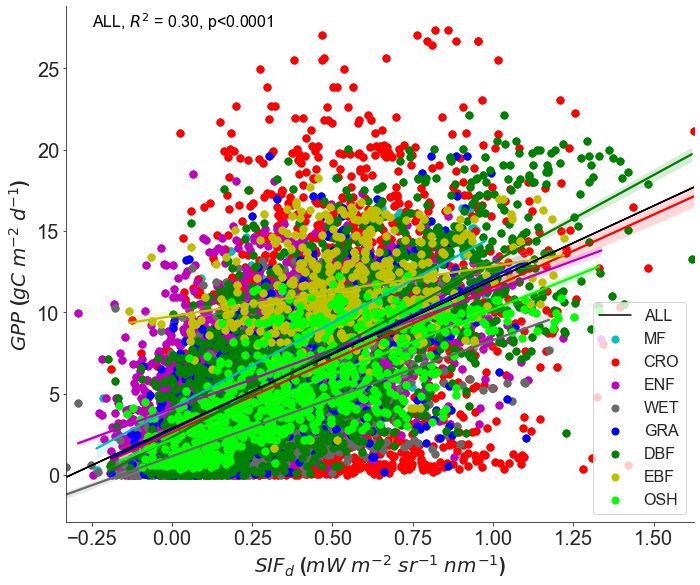

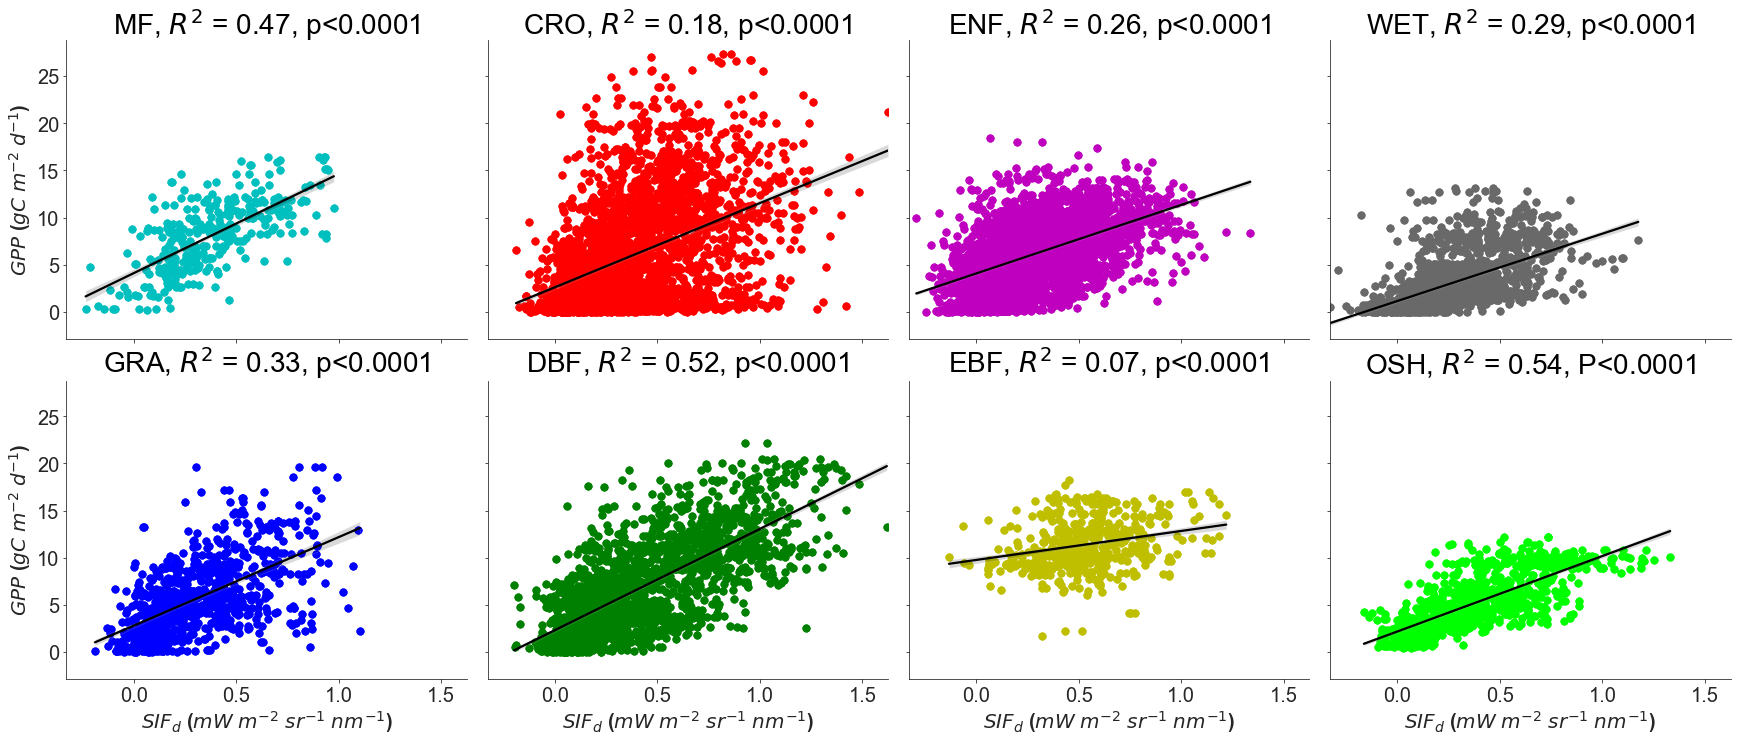

In [10]:
# Convert site name to list

list_Sites = df_merge["Site_name"].unique().tolist()

# Sorting your site list
list_Sites = sorted(list_Sites)
print(list_Sites)
df_merge.sort_values('Site_name', inplace =True)

##################################################################################################################
plt.rc('legend', fontsize= 16) #fontsize of the legend
plt.rc('axes', titlesize=28) #fontsize of the title

from scipy import stats
from scipy.stats import linregress
import scipy as sp

sns.set_style("ticks")
#########################################################################################################################
# Generate a scatter plot of the linear regression between SIF and GPP

# color dictionary

color_dict = dict({'MF':'c',
                  'DBF':'g',
                  'EBF': 'y',
                  'CRO': 'r',
                   'ENF': 'm',
                  'GRA': 'b',
                  'WET': 'dimgrey','OSH': 'lime',
                  })

######################################################################################################################################################
Site_palette = dict({"BE-Bra":"c","BE-Lcr":"r","BE-Lon":"r","BE-Vie":"m","CH-Dav":"m","CZ-BK1":"m","CZ-Lnz":"g","CZ-Wet":"c",
                    "DE-Geb":"r","DE-Gri":"m","DE-Hai":"g","DE-HoH":"g","DE-Hzd":"m", "DE-Kli":"r","DE-RuR":"g","DE-RuS":"r","DE-RuW":"m",
                    "DE-Tha":"c", "DK-Sor":"g","FI-Hyy":"m","FI-Sii":"m","FI-Var":"m","FR-Aur":"r","FR-Bil":"m","FR-EM2":"r","FR-Fon":"g",
                    "FR-Hes":"g","FR-LGt":"c","FR-Mej":"r","GF-Guy":"y","IT-BCi":"r","IT-Cp2":"y","IT-Lsn":"r","IT-SR2":"c","IT-Tor":"b",
                     "NL-Loo":"m","SE-Deg":"m","SE-Htm":"m","SE-Htm":"m","SE-Nor":"m","SE-Svb":"m"})

################################################################################################################################################

# Testing the genericity of the linear relationship between GPP and SIF

#sns.lmplot plot data and regression model fits across a FacetGrid: combines regplot and FacetGrid data

ax = sns.lmplot(x="SIF_Daily", y="GPP", hue="Biome_site",
              data=df_merge, palette=color_dict, scatter_kws={"s": 50, "alpha": 1},legend_out = False
                , markers=["o", "o","o", "o","o","o","o","o"], height=8, aspect=1.2)

plt.xlabel( "$SIF_d$ ($mW$ $m^{-2}$ $sr^{-1}$ $nm^{-1}$)", weight='bold')
plt.ylabel( "$GPP$ ($gC$ $m$$^{-2}$ $d$$^{-1}$)", weight='bold')

LR = stats.linregress(df_merge['SIF_Daily'],  df_merge['GPP'])

line = LR.slope*df_merge['SIF_Daily'] + (LR.intercept)

plt.plot(df_merge['SIF_Daily'], line, 'k', label = 'ALL')

plt.text(-0.25,27.5 , 'ALL, $R^2$ = 0.30, p<0.0001', color = 'k')

plt.legend(loc = 'lower right')

#ax.savefig('Lreg_biome_all_filtered_site.svg', dpi=500) # uncomment this line to save your plot in your working directory

#################################################################################################################################

# Biome specific SIF-GPP Relation using sns.lmplot

lm = sns.lmplot(x="SIF_Daily", y="GPP", hue="Biome_site", col ='Biome_site', col_wrap=4,
              data=df_merge, palette=color_dict, scatter_kws={"s": 50, "alpha": 1}, legend_out = False,
                 markers=["o", "o","o", "o","o","o","o","o"], height=5, aspect=1.2, line_kws={'color': 'black'})

lm.set_axis_labels("$SIF_d$ ($mW$ $m^{-2}$ $sr^{-1}$ $nm^{-1}$)", "$GPP$ ($gC$ $m$$^{-2}$ $d$$^{-1}$)", weight='bold')
lm.set_titles(col_template ='{col_name}')
ax = lm.axes

ax[0].set_title('MF, $R^2$ = 0.47, p<0.0001', color = 'k')
ax[1].set_title('CRO, $R^2$ = 0.18, p<0.0001', color = 'k')
ax[2].set_title('ENF, $R^2$ = 0.26, p<0.0001', color = 'k')
ax[3].set_title('WET, $R^2$ = 0.29, p<0.0001', color = 'k')
ax[4].set_title('GRA, $R^2$ = 0.33, p<0.0001', color = 'k')
ax[5].set_title('DBF, $R^2$ = 0.52, p<0.0001', color = 'k')
ax[6].set_title('EBF, $R^2$ = 0.07, p<0.0001', color = 'k')
ax[7].set_title('OSH, $R^2$ = 0.54, P<0.0001', color = 'k')

#lm.savefig('Lreg_biome_all_filtered.svg', dpi=500) # uncomment this line to save your plot in your working directory


['CRO-1', 'CRO-2', 'CRO-3', 'CRO-4', 'CRO-5', 'CRO-6', 'CRO-7', 'CRO-8', 'CRO-9', 'DBF-1', 'DBF-2', 'DBF-3', 'DBF-4', 'DBF-5', 'DBF-6', 'EBF-1', 'EBF-2', 'ENF-1', 'ENF-10', 'ENF-11', 'ENF-12', 'ENF-13', 'ENF-2', 'ENF-3', 'ENF-4', 'ENF-5', 'ENF-6', 'ENF-7', 'ENF-8', 'ENF-9', 'GRA-1', 'GRA-2', 'GRA-3', 'MF-1', 'MF-2', 'OSH-1', 'WET-1', 'WET-2', 'WET-3', 'WET-4']


Text(0.5, 1.0, 'SE-Deg, $R^2$ = 0.35')

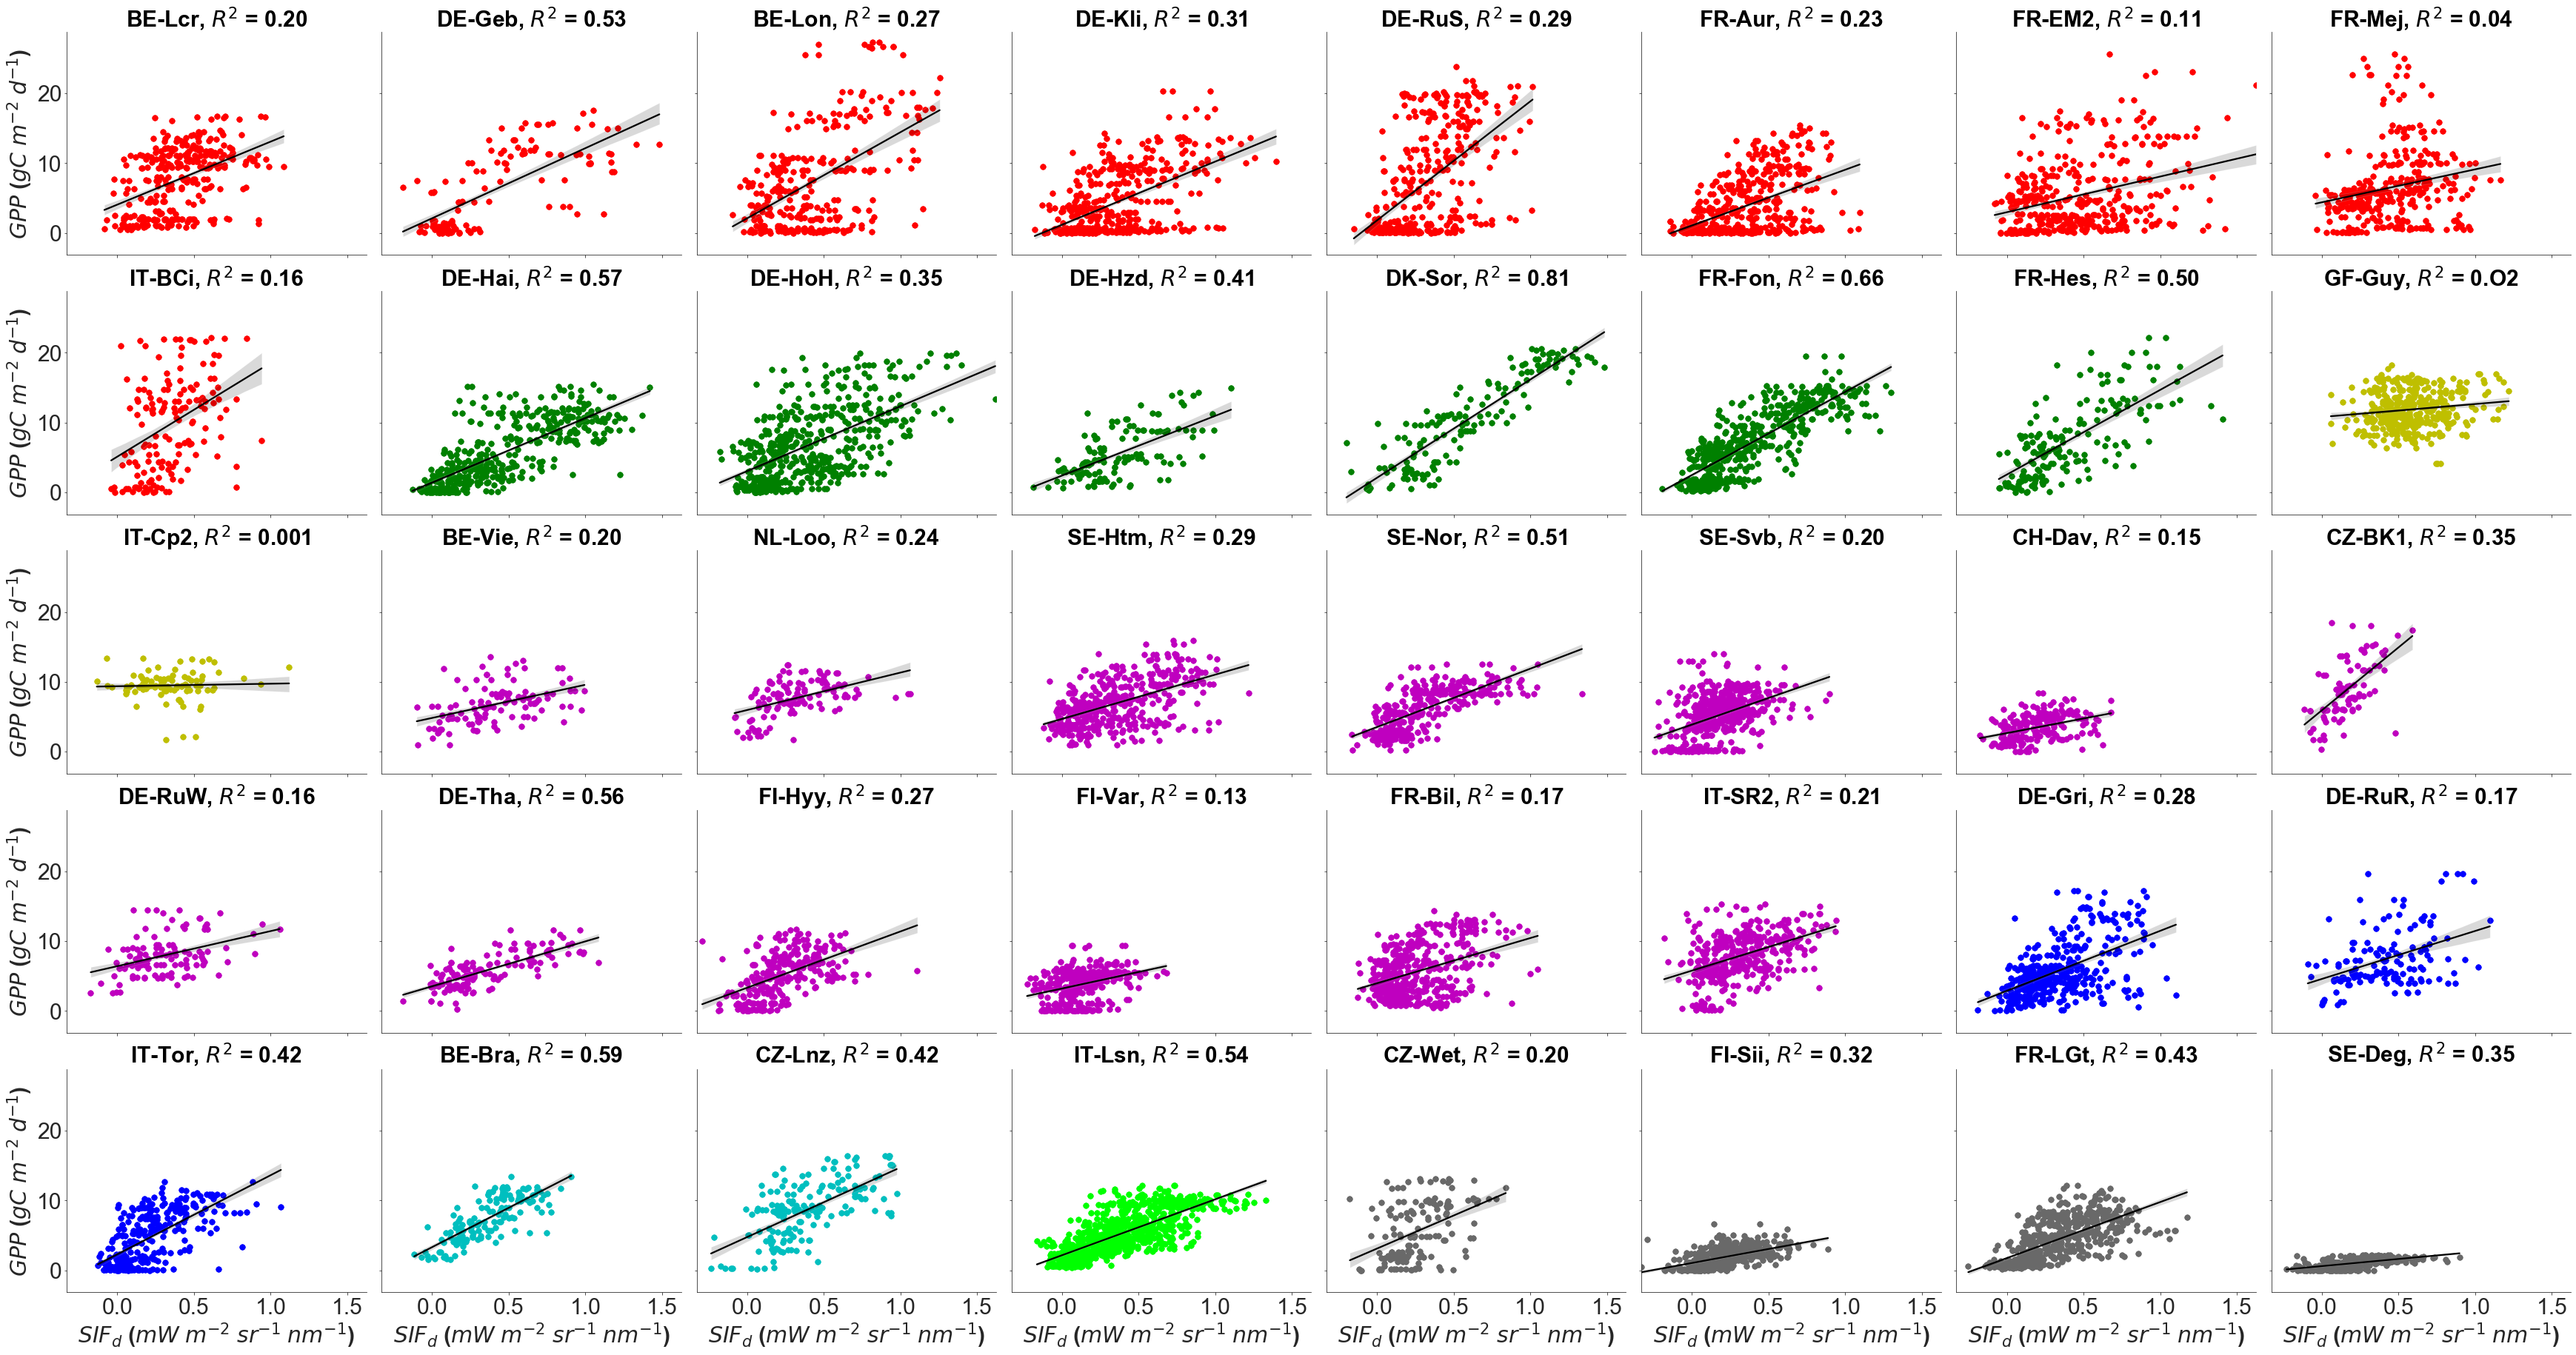

In [12]:
#Generating site-specific GPP and SIF relationship plots
##############################################################################################################
#Data preparation
# Replace site name by their vegetation type name for grouping according biomes

df_merge.loc[df_merge["Site_palette"] == "BE-Bra", "Site_palette"] = 'MF-1'
df_merge.loc[df_merge["Site_palette"] == "CZ-Lnz","Site_palette"] = 'MF-2'

df_merge.loc[df_merge["Site_palette"] == "BE-Lcr", "Site_palette"] = 'CRO-1'
df_merge.loc[df_merge["Site_palette"] == "DE-Geb", "Site_palette"] = 'CRO-2'
df_merge.loc[df_merge["Site_palette"] == "BE-Lon", "Site_palette"] = 'CRO-3'
df_merge.loc[df_merge["Site_palette"] == "DE-Kli", "Site_palette"] = 'CRO-4'
df_merge.loc[df_merge["Site_palette"] == "DE-RuS", "Site_palette"] = 'CRO-5'
df_merge.loc[df_merge["Site_palette"] == "FR-Aur", "Site_palette"] = 'CRO-6'
df_merge.loc[df_merge["Site_palette"] == "FR-EM2", "Site_palette"] = 'CRO-7'
df_merge.loc[df_merge["Site_palette"] == "FR-Mej", "Site_palette"] = 'CRO-8'
df_merge.loc[df_merge["Site_palette"] == "IT-BCi", "Site_palette"] = 'CRO-9'

df_merge.loc[df_merge["Site_palette"] == "BE-Vie", "Site_palette"] = 'ENF-1'
df_merge.loc[df_merge["Site_palette"] == "CH-Dav", "Site_palette"] = 'ENF-2'
df_merge.loc[df_merge["Site_palette"] == "CZ-BK1", "Site_palette"] = 'ENF-3'
df_merge.loc[df_merge["Site_palette"] == "DE-RuW", "Site_palette"] = 'ENF-4'
df_merge.loc[df_merge["Site_palette"] == "DE-Tha", "Site_palette"] = 'ENF-5'
df_merge.loc[df_merge["Site_palette"] == "FI-Hyy", "Site_palette"] = 'ENF-6'
df_merge.loc[df_merge["Site_palette"] == "FI-Var", "Site_palette"] = 'ENF-7'
df_merge.loc[df_merge["Site_palette"] == "FR-Bil", "Site_palette"] = 'ENF-8'
df_merge.loc[df_merge["Site_palette"] == "IT-SR2", "Site_palette"] = 'ENF-9'
df_merge.loc[df_merge["Site_palette"] == "NL-Loo", "Site_palette"] = 'ENF-10'
df_merge.loc[df_merge["Site_palette"] == "SE-Htm", "Site_palette"] = 'ENF-11'
df_merge.loc[df_merge["Site_palette"] == "SE-Nor", "Site_palette"] = 'ENF-12'
df_merge.loc[df_merge["Site_palette"] == "SE-Svb", "Site_palette"] = 'ENF-13'

df_merge.loc[df_merge["Site_palette"] == "DE-Hai", "Site_palette"] = 'DBF-1'
df_merge.loc[df_merge["Site_palette"] == "DE-HoH", "Site_palette"] = 'DBF-2'
df_merge.loc[df_merge["Site_palette"] == "DE-Hzd", "Site_palette"] = 'DBF-3'
df_merge.loc[df_merge["Site_palette"] == "DK-Sor", "Site_palette"] = 'DBF-4'
df_merge.loc[df_merge["Site_palette"] == "FR-Fon", "Site_palette"] = 'DBF-5'
df_merge.loc[df_merge["Site_palette"] == "FR-Hes", "Site_palette"] = 'DBF-6'

df_merge.loc[df_merge["Site_palette"] == "GF-Guy", "Site_palette"] = 'EBF-1'
df_merge.loc[df_merge["Site_palette"] == "IT-Cp2", "Site_palette"] = 'EBF-2'

df_merge.loc[df_merge["Site_palette"] == "DE-Gri", "Site_palette"] = 'GRA-1'
df_merge.loc[df_merge["Site_palette"] == "DE-RuR", "Site_palette"] = 'GRA-2'
df_merge.loc[df_merge["Site_palette"] == "IT-Tor", "Site_palette"] = 'GRA-3'

df_merge.loc[df_merge["Site_palette"] == "CZ-Wet", "Site_palette"] = 'WET-1'
df_merge.loc[df_merge["Site_palette"] == "FI-Sii", "Site_palette"] = 'WET-2'
df_merge.loc[df_merge["Site_palette"] == "FR-LGt","Site_palette"] = 'WET-3'
df_merge.loc[df_merge["Site_palette"] == "SE-Deg", "Site_palette"] = 'WET-4'

df_merge.loc[df_merge["Site_palette"] == "IT-Lsn", "Site_palette"] = 'OSH-1'
################################################################################################################

list_Sites = df_merge["Site_palette"].unique().tolist()
# Sorting your biome list

list_Sites = sorted(list_Sites)
print(list_Sites)
df_merge.sort_values('Site_palette', inplace =True)
#########################################################################################################################
# Site specific SIF-GPP Relation using sns.lmplot
sns.set_style("ticks")

plt.rc('axes', titlesize=35) #fontsize of the title
plt.rc('xtick', labelsize=30) #fontsize of the x tick labels
plt.rc('ytick', labelsize=30) #fontsize of the y tick labels
plt.rc('legend', fontsize=30) #fontsize of the legend
plt.rc('axes', titlesize=30) #fontsize of the title
plt.rc('axes', labelsize=30) #fontsize of the x and y labels


###############################################################################################################################################
                    
Site_palette2 = dict({"CRO-1":"r","CRO-2":"r","CRO-3":"r","CRO-4":"r","CRO-5":"r","CRO-6":"r","CRO-7":"r","CRO-8":"r","CRO-9":"r",
                      "DBF-1":"g","DBF-2":"g","DBF-3":"g", "DBF-4":"g","DBF-5":"g","DBF-6":"g","EBF-1":"y","EBF-2":"y",
                      "ENF-1":"m","ENF-10":"m","ENF-11":"m","ENF-12":"m","ENF-13":"m","ENF-2":"m","ENF-3":"m","ENF-4":"m",
                      "ENF-5":"m","ENF-6":"m","ENF-7":"m","ENF-8":"m","ENF-9":"m","GRA-1":"b","GRA-2":"b","GRA-3":"b", "MF-1":"c","MF-2":"c",
                      "OSH-1":"lime", "WET-1":"dimgrey","WET-2":"dimgrey","WET-3":"dimgrey","WET-4":"dimgrey"
                      })

##############################################################################################################################

# Site specific SIF-GPP Relation using sns.lmplot

lm = sns.lmplot(x="SIF_Daily", y="GPP", hue="Site_palette",col ='Site_palette',col_wrap=8,
              data=df_merge, scatter_kws={"s": 50, "alpha": 1},legend_out = False
                , height=5, aspect=1.2, palette = Site_palette2, line_kws={'color': 'black'})

lm.set_axis_labels("$SIF_d$ ($mW$ $m$$^{-2}$ $sr$$^{-1}$ $nm$$^{-1}$)", "$GPP$ ($gC$ $m$$^{-2}$ $d$$^{-1}$)", weight='bold')
lm.set_titles(col_template ='{col_name}')

ax = lm.axes

ax[0].set_title('BE-Lcr, $R^2$ = 0.20', color = 'k',weight ='bold')
ax[1].set_title('DE-Geb, $R^2$ = 0.53', color = 'k',weight ='bold' )
ax[2].set_title('BE-Lon, $R^2$ = 0.27', color = 'k',weight ='bold')
ax[3].set_title('DE-Kli, $R^2$ = 0.31', color = 'k', weight ='bold')
ax[4].set_title('DE-RuS, $R^2$ = 0.29', color = 'k', weight ='bold')
ax[5].set_title('FR-Aur, $R^2$ = 0.23', color = 'k', weight ='bold')
ax[6].set_title('FR-EM2, $R^2$ = 0.11', color = 'k',weight ='bold' )
ax[7].set_title('FR-Mej, $R^2$ = 0.04', color = 'k', weight ='bold')
ax[8].set_title('IT-BCi, $R^2$ = 0.16', color = 'k', weight ='bold')

ax[9].set_title('DE-Hai, $R^2$ = 0.57', color = 'k',weight ='bold')
ax[10].set_title('DE-HoH, $R^2$ = 0.35', color = 'k',weight ='bold')
ax[11].set_title('DE-Hzd, $R^2$ = 0.41', color = 'k', weight ='bold')
ax[12].set_title('DK-Sor, $R^2$ = 0.81', color = 'k',weight ='bold')
ax[13].set_title('FR-Fon, $R^2$ = 0.66', color = 'k',weight ='bold')
ax[14].set_title('FR-Hes, $R^2$ = 0.50', color = 'k',weight ='bold')

ax[15].set_title('GF-Guy, $R^2$ = 0.O2', color = 'k', weight ='bold')
ax[16].set_title('IT-Cp2, $R^2$ = 0.001', color = 'k', weight ='bold')

ax[17].set_title('BE-Vie, $R^2$ = 0.20', color = 'k',weight ='bold')
ax[18].set_title('NL-Loo, $R^2$ = 0.24', color = 'k',weight ='bold')
ax[19].set_title('SE-Htm, $R^2$ = 0.29', color = 'k', weight ='bold')
ax[20].set_title('SE-Nor, $R^2$ = 0.51', color = 'k', weight ='bold')
ax[21].set_title('SE-Svb, $R^2$ = 0.20', color = 'k', weight ='bold')
ax[22].set_title('CH-Dav, $R^2$ = 0.15', color = 'k', weight ='bold')
ax[23].set_title('CZ-BK1, $R^2$ = 0.35', color = 'k', weight ='bold')
ax[24].set_title('DE-RuW, $R^2$ = 0.16', color = 'k',weight ='bold' )
ax[25].set_title('DE-Tha, $R^2$ = 0.56', color = 'k',weight ='bold')
ax[26].set_title('FI-Hyy, $R^2$ = 0.27', color = 'k',weight ='bold')
ax[27].set_title('FI-Var, $R^2$ = 0.13', color = 'k', weight ='bold')
ax[28].set_title('FR-Bil, $R^2$ = 0.17', color = 'k', weight ='bold')
ax[29].set_title('IT-SR2, $R^2$ = 0.21', color = 'k',weight ='bold')

ax[30].set_title('DE-Gri, $R^2$ = 0.28', color = 'k',weight ='bold')
ax[31].set_title('DE-RuR, $R^2$ = 0.17', color = 'k', weight ='bold')
ax[32].set_title('IT-Tor, $R^2$ = 0.42', color = 'k',weight ='bold')

ax[33].set_title('BE-Bra, $R^2$ = 0.59', color = 'k',weight ='bold' )
ax[34].set_title('CZ-Lnz, $R^2$ = 0.42', color = 'k', weight ='bold')

ax[35].set_title('IT-Lsn, $R^2$ = 0.54', color = 'k',weight ='bold' )

ax[36].set_title('CZ-Wet, $R^2$ = 0.20', color = 'k', weight ='bold')
ax[37].set_title('FI-Sii, $R^2$ = 0.32', color = 'k', weight ='bold')
ax[38].set_title('FR-LGt, $R^2$ = 0.43', color = 'k',weight ='bold')
ax[39].set_title('SE-Deg, $R^2$ = 0.35', color = 'k', weight ='bold')

# Save your figure
#lm.savefig('Lreg_SIF_GPP_Sites_all_t35.svg',dpi=500) # uncomment this line to save your plot in your working directory


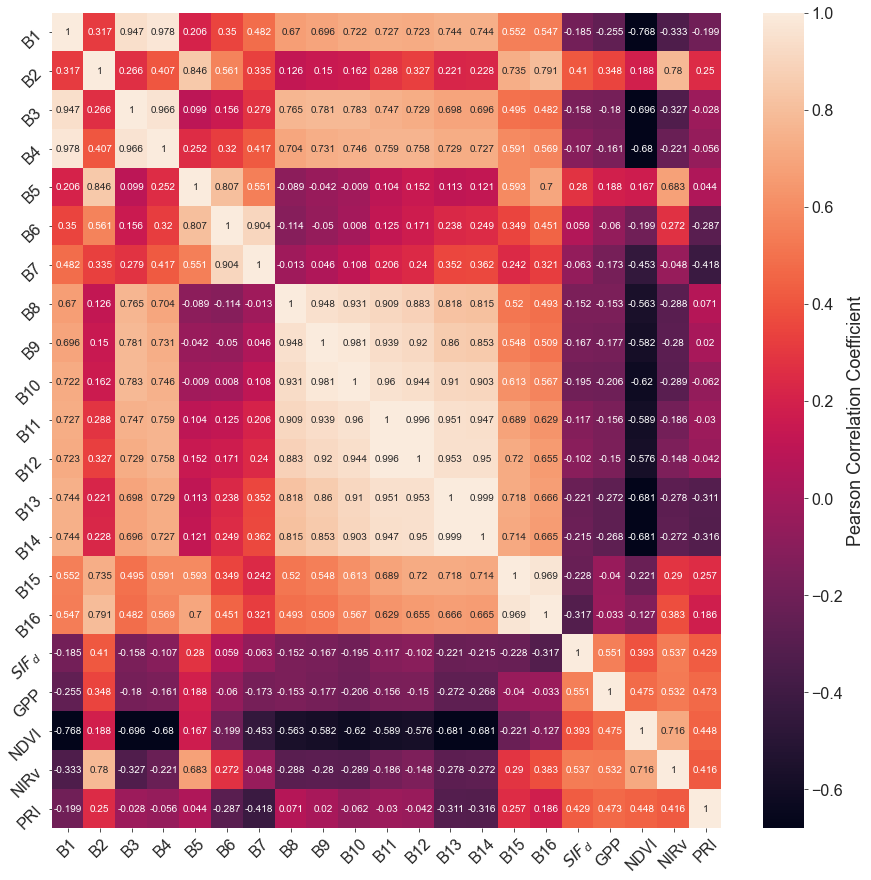

In [14]:
# Generate the correlation matrix from all explanatory variables and target
#select your variables from the dataframe
columns = ['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','B13','B14','B15','B16',
           'SIF_Daily', 'GPP', 'NDVI', 'NIRv','PRI13']

# create a new dataframe
Data = df_merge[columns]

# rename the columns
Data.rename(columns ={'PRI13':'PRI', 'IGBP_LCnum':'IGBP_Biome', 'SIF_Daily':'$SIF_d$', 'GPP':'GPP'}, inplace =True)

##################################################################################################################################
# generate your correlation matrix heatmap

plt.rc('font', size=10) #controls default text sizesns.set_style('whitegrid')
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend
plt.rc('axes', titlesize=18) #fontsize of the title
plt.rc('axes', labelsize=18) #fontsize of the x and y labels


fig, ax = plt.subplots(figsize=(15,15))
corrmatrix = round(Data.corr(method ='pearson'),3)
ax = sns.heatmap(data = corrmatrix, fmt='.4g', robust =True,
                 annot = True, cbar_kws={'label': 'Pearson Correlation Coefficient'}
                ,)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#fig.savefig('Heatmap_correlation2.svg', dpi = 500)  # uncomment this line to save your plot in your working directory
